<a href="https://colab.research.google.com/github/RaynoldPanjiZ/cat-dog-Transfer-Learning/blob/main/cat%26dog_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# %tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Data Preparation

### Download Datasets

In [ ]:
!pip install -q kaggle
from google.colab import files 

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats

 97% 788M/812M [00:04<00:00, 143MB/s]
100% 812M/812M [00:04<00:00, 187MB/s]


In [ ]:
!mkdir datasets
!unzip -q dogs-vs-cats.zip -d datasets
!unzip -q datasets/test1.zip -d datasets
!unzip -q datasets/train.zip -d datasets
# !mv datasets/test1 datasets/test

In [ ]:
!mkdir datasets/data
!mv datasets/train datasets/data
!mv datasets/test1 datasets/data

In [ ]:
!ls datasets/data/train | wc -l
!ls datasets/data/test1 | wc -l

25000
12500


### Create datasets csv

In [ ]:
import os
import pandas as pd

filenames=os.listdir('datasets/data/train')
categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]
    if category=='dog':
        categories.append('dog')
    else:
        categories.append('cat')
df=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

df

,filename,category
0,dog.9152.jpg,dog
1,dog.10394.jpg,dog
2,dog.8447.jpg,dog
3,cat.11217.jpg,cat
4,dog.1112.jpg,dog
...,...,...
24995,cat.8494.jpg,cat
24996,dog.12461.jpg,dog
24997,cat.12002.jpg,cat
24998,dog.7587.jpg,dog


In [ ]:
## Splitting dataset

from sklearn.model_selection import train_test_split

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

total_train=train_df.shape[0]
total_validate=validate_df.shape[0]

total_train, total_validate

(20000, 5000)

# Data Preprocessing

In [ ]:
import cv2
import inspect

import itertools
import random
import glob

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Number of training examples and labels
batch_size = 32

num_train = total_train
num_validation = total_validate
num_classes = 2
num_iterations = int(num_train/batch_size)

# Print important info
print(f'Num train images: {num_train} \
        \nNum validation images: {num_validation} \
        \nNum classes: {num_classes} \
        \nNum iterations per epoch: {num_iterations}')

Num train images: 20000         
Num validation images: 5000         
Num classes: 2         
Num iterations per epoch: 625


In [ ]:
from keras.preprocessing.image import ImageDataGenerator, load_img
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=15,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

validation_datagen = ImageDataGenerator(rescale=1./255)



train_generator = train_datagen.flow_from_dataframe(
    train_df,
    'datasets/data/train', 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=batch_size
)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    'datasets/data/train', 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [ ]:
# def normalize_img(image, label, img_size):
#     # Resize image to the desired img_size and normalize it
#     # One hot encode the label
#     image = tf.image.resize(image, img_size)
#     image = tf.cast(image, tf.float32) / 255.
#     label = tf.one_hot(label, depth=num_classes)
#     return image, label

# def preprocess_data(train, validation, batch_size, img_size):
#     # Apply the normalize_img function on all train and validation data and create batches
#     train_processed = train.map(lambda image, label: normalize_img(image, label, img_size))
#     train_processed = train_processed.batch(batch_size).repeat()

#     validation_processed = validation.map(lambda image, label: normalize_img(image, label, img_size))
#     validation_processed = validation_processed.batch(batch_size)

#     return train_processed, validation_processed

# # Run preprocessing
# train_processed_224, validation_processed_224 = preprocess_data(train, validation, batch_size, img_size=[224,224])
# train_processed_331, validation_processed_331 = preprocess_data(train, validation, batch_size, img_size=[331,331])

# Training

In [ ]:
## Define Callbacks

from tf.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def callbacks():
  earlystop = EarlyStopping(patience = 10)
  learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
  cb = [earlystop, learning_rate_reduction]
  return cb

In [ ]:
from tqdm import tqdm
import numpy as np

if not os.path.exists('model'):
    os.makedirs('model')

## import pre-train model
model_dictionary={
    'MobileNetV2': tf.keras.applications.MobileNetV2,
    'ResNet50V2': tf.keras.applications.ResNet50V2
}

## define benchmark metric model
model_benchmarks = {
    'model_name': [], 
    'num_model_params': [], 
    'epoch': [], 
    'train_accuracy': [], 
    'validation_accuracy': [], 
    'train_loss': [], 
    'validation_loss': []
}

## Loop over each model available in Keras
for model_name, model in tqdm(model_dictionary.items()):
    # Special handling for input images with size (224,224)
    input_shape=(224,224,3)
    train_processed = train_generator
    validation_processed = validation_generator
    weight = 'imagenet'

    # load the pre-trained model with global average pooling as the last layer and freeze the model weights
    pre_trained_model = model(
        input_shape=input_shape,
        include_top=False, 
        weights=weight, 
        pooling='avg'
    )
    pre_trained_model.trainable = False

    # custom modifications on top of pre-trained model
    clf_model = tf.keras.models.Sequential()
    clf_model.add(pre_trained_model)
    clf_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    clf_model.compile(
        loss='categorical_crossentropy', 
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.001),
        metrics=['accuracy']
    )
    history = clf_model.fit(
        train_processed, 
        epochs=5, 
        validation_data=validation_processed, 
        steps_per_epoch=num_iterations
    )

    clf_model.save(f"model/model_{model_name}.h5")

    # Calculate all relevant metrics
    model_benchmarks['model_name'].append(model_name)
    model_benchmarks['num_model_params'].append(pre_trained_model.count_params())
    model_benchmarks['epoch'].append(list(np.array(history.epoch)+1))
    model_benchmarks['train_accuracy'].append(history.history['accuracy'])
    model_benchmarks['validation_accuracy'].append(history.history['val_accuracy'])
    model_benchmarks['train_loss'].append(history.history['loss'])
    model_benchmarks['validation_loss'].append(history.history['val_loss'])

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/5
625/625 [==============================] - 270s 429ms/step - loss: 0.0820 - accuracy: 0.9682 - val_loss: 0.0542 - val_accuracy: 0.9816
Epoch 2/5
625/625 [==============================] - 261s 418ms/step - loss: 0.0646 - accuracy: 0.9760 - val_loss: 0.0578 - val_accuracy: 0.9812
Epoch 3/5
625/625 [==============================] - 276s 441ms/step - loss: 0.0617 - accuracy: 0.9764 - val_loss: 0.0614 - val_accuracy: 0.9812
Epoch 4/5
625/625 [==============================] - 271s 433ms/step - loss: 0.0593 - accuracy: 0.9772 - val_loss: 0.0715 - val_accuracy: 0.9768
Epoch 5/5
625/625 [==============================] - 272s 435ms/step - loss: 0.0580 - accuracy: 0.9783 - val_loss: 0.0592 - val_accuracy: 0.9804


 50%|█████     | 1/2 [23:23<23:23, 1403.33s/it]

94683136/94668760 [==============================] - 0s 0us/step
Epoch 1/5
625/625 [==============================] - 342s 460ms/step - loss: 0.0739 - accuracy: 0.9729 - val_loss: 0.0529 - val_accuracy: 0.9832
Epoch 2/5
625/625 [==============================] - 280s 448ms/step - loss: 0.0529 - accuracy: 0.9808 - val_loss: 0.0370 - val_accuracy: 0.9892
Epoch 3/5
625/625 [==============================] - 278s 445ms/step - loss: 0.0487 - accuracy: 0.9828 - val_loss: 0.0428 - val_accuracy: 0.9872
Epoch 4/5
625/625 [==============================] - 289s 463ms/step - loss: 0.0530 - accuracy: 0.9823 - val_loss: 0.0534 - val_accuracy: 0.9834
Epoch 5/5
625/625 [==============================] - 312s 499ms/step - loss: 0.0484 - accuracy: 0.9844 - val_loss: 0.0519 - val_accuracy: 0.9850


100%|██████████| 2/2 [48:26<00:00, 1453.48s/it]


In [ ]:
model_benchmarks

# Visualize model

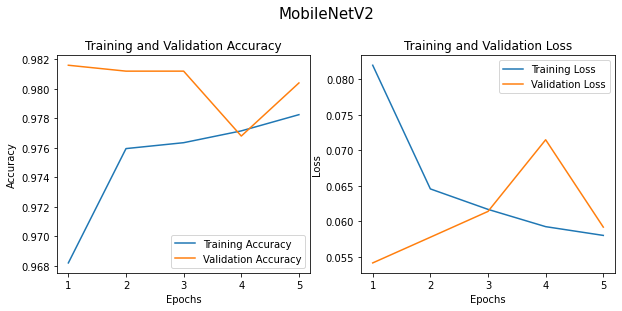

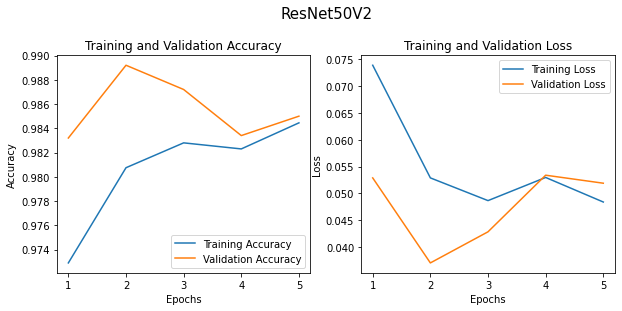

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

if not os.path.exists('visualize'):
    os.makedirs('visualize')

## plot accuracy dan loss
for i in range(2):

  epoch_list = model_benchmarks['epoch'][i]
  name = model_benchmarks['model_name'][i]

  acc = model_benchmarks['train_accuracy'][i]
  val_acc = model_benchmarks['validation_accuracy'][i]

  loss = model_benchmarks['train_loss'][i]
  val_loss = model_benchmarks['validation_loss'][i]


  plt.figure(figsize=(10, 4))
  plt.suptitle(name, y=1.05, fontsize=15)

  plt.subplot(1, 2, 1)
  plt.plot(epoch_list, acc, label='Training Accuracy')
  plt.plot(epoch_list, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epoch_list, loss, label='Training Loss')
  plt.plot(epoch_list, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

  plt.savefig(f'visualize/plot{name[i]}.png')
plt.show()

In [ ]:
benchmark_df = pd.DataFrame(
    {
        'model_name': model_benchmarks['model_name'], 
        'num_model_params': model_benchmarks['num_model_params'], 
        'train_accuracy': [a[-1] for a in model_benchmarks['train_accuracy']],
        'validation_accuracy': [a[-1] for a in model_benchmarks['validation_accuracy']],
        'train_loss': [a[-1] for a in model_benchmarks['train_loss']],
        'validation_loss': [a[-1] for a in model_benchmarks['validation_loss']]
    }
)

benchmark_df.sort_values('num_model_params', inplace=True) # sorting ascending berdasarkan num_model_params
benchmark_df.to_csv('visualize/benchmark_df.csv', index=False) # write results to csv
benchmark_df

,model_name,num_model_params,train_accuracy,validation_accuracy,train_loss,validation_loss
0,MobileNetV2,2257984,0.97825,0.9804,0.058034,0.059201
1,ResNet50V2,23564800,0.98445,0.9850,0.048388,0.051899


# Predict val data

In [ ]:
## Load model
from keras.models import load_model
savedModel = load_model('model/model_MobileNetV2.h5')

In [ ]:
## predict model
nb_samples = validate_df.shape[0]
predict = savedModel.predict_generator(validation_generator, steps=np.ceil(nb_samples/batch_size))

## mapping label output
pred_label = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
pred_label = [label_map[p] for p in pred_label]  

pred_label[0], label_map[0]

In [ ]:
## convert to dataframe
predict_df = pd.DataFrame(validate_df)
predict_df['pred_label'] = pred_label
predict_df['prob'] = np.max(predict, axis=-1)

predict_df.to_csv('visualize/pred_validate.csv', index=False)

predict_df.head(10)

,filename,category,pred_label,prob
0,cat.8611.jpg,cat,dog,0.999938
1,cat.8023.jpg,cat,dog,0.999904
2,dog.8745.jpg,dog,dog,0.998779
3,cat.1088.jpg,cat,dog,0.999929
4,dog.153.jpg,dog,dog,0.999998
5,dog.2490.jpg,dog,cat,0.958921
6,dog.4478.jpg,dog,dog,0.989758
7,cat.11236.jpg,cat,cat,0.999938
8,cat.7803.jpg,cat,dog,0.999203
9,dog.8054.jpg,dog,cat,0.977190


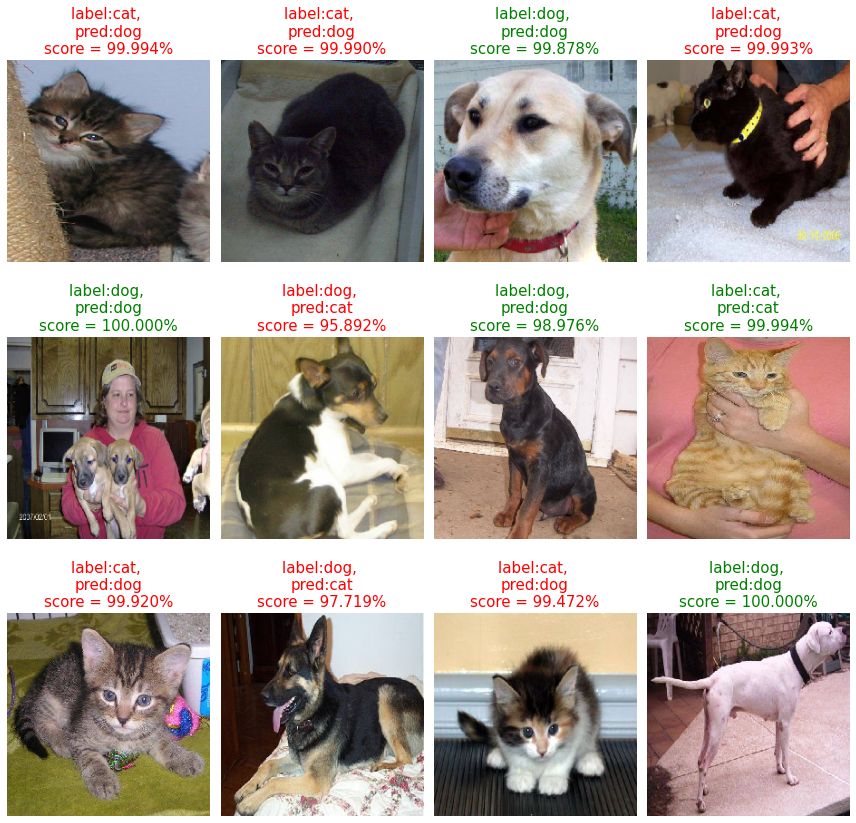

In [ ]:
## plot image predicted
sample_test = predict_df.head(12)
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    pred_label = row['pred_label']
    prob = row['prob']
    img = load_img("datasets/data/train/"+filename, target_size=(224,224))
    plt.subplot(3, 4, index+1)
    plt.imshow(img)
    plt.title(
      label=f"actual: {category}, \npredict: {pred_label}\nscore = {(prob*100):.3f}%",
      color=('g' if category==pred_label else 'r'), 
      fontdict={'fontsize':15} 
    )
    plt.axis("off")
plt.tight_layout()
plt.show()

# Predict test1 data

In [ ]:
test_filenames=os.listdir('datasets/data/test1')

test_df = pd.DataFrame(
    test_filenames, columns=['filename']
)
test_df

,filename
0,4895.jpg
1,5555.jpg
2,10452.jpg
3,173.jpg
4,1672.jpg
...,...
12495,6138.jpg
12496,4164.jpg
12497,2497.jpg
12498,3324.jpg


In [ ]:
from keras.preprocessing import image

sample_test = test_df['filename']
label_map = {0: 'cat', 1: 'dog'}

images = []

pred = {
    'pred_label':[],
    'prob':[]
}

## mapping label output
for img in sample_test:
    img = os.path.join('datasets/data/test1', img)
    img = image.load_img(img, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = np.vstack([img])
    # images.append(img)

    predict = savedModel.predict(img)
    pred_label = np.argmax(predict, axis=-1)
    pred['pred_label'] = label_map[pred_label[0]]
    pred['prob'] = np.max(predict, axis=-1)[0]

## convert to dataframe
test_df['pred_label'] = pred['pred_label']
test_df['prob'] = pred['prob']
test_df

,filename,pred_label,prob
0,4895.jpg,cat,0.780484
1,5555.jpg,cat,0.780484
2,10452.jpg,cat,0.780484
3,173.jpg,cat,0.780484
4,1672.jpg,cat,0.780484
...,...,...,...
12495,6138.jpg,cat,0.780484
12496,4164.jpg,cat,0.780484
12497,2497.jpg,cat,0.780484
12498,3324.jpg,cat,0.780484


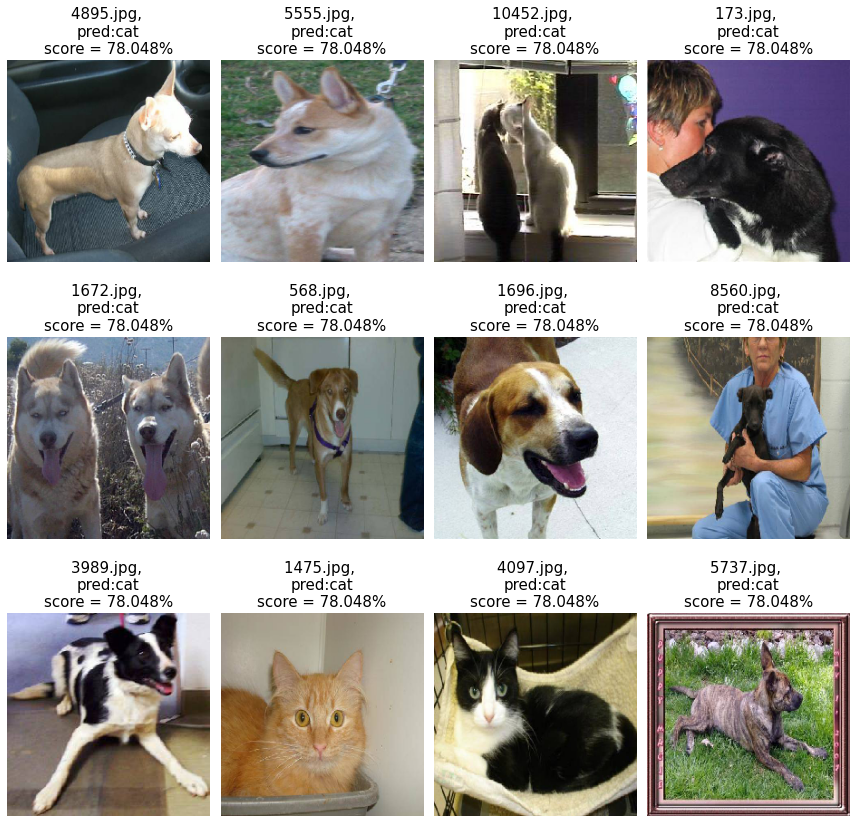

In [ ]:
sample_test = test_df.head(12)
# sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    pred_label = row['pred_label']
    prob = row['prob']
    img = load_img("datasets/data/test1/"+filename, target_size=(224,224))
    plt.subplot(3, 4, index+1)
    plt.imshow(img)
    plt.title(
      label=f"{filename}, \npred:{pred_label}\nscore = {(prob*100):.3f}%",
      fontdict={'fontsize':15} 
    )
    plt.axis("off")
plt.tight_layout()
plt.show()

# Predict from input

Saving dog2.jpeg to dog2.jpeg
Image : dog2.jpeg

Result :
dog


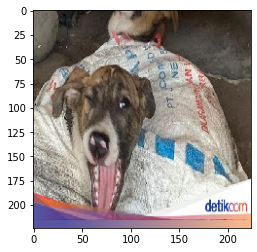

In [ ]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(224,224))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = savedModel.predict(images, batch_size=10)

  # templating output
  cat     = "[[1. 0.]]"
  dog      = "[[0. 1.]]"
  
  # convert numpy array to string
  result = np.array_str(classes) 
  
  
  print('Image : ' + fn)

  print('\nResult :')
  if result == cat:
    print('cat')
  elif result == dog:
    print('dog')
  else:
    print('No result found !')


**Reference** : https://towardsdatascience.com/how-to-choose-the-best-keras-pre-trained-model-for-image-classification-b850ca4428d4